#**Comparacion de dos modelos de DL para clasificacion de audio**

Se utlilizara el dataset UrbanSound8K cuya descripcion esta en el documento datasets para estos informes

El aporte de este estudio:
 - Poder escoger, de los entrenamientos y evaluaciones, el de mejor rendimiento, usando `callbacks`.
 - Detener la ejecucion de los entrenamientos y evaluaciones, cuando se degraden los rendimienrtos, usando el modulo `Early`.

##**Verificacion de la existencia de GPUs y la asignacion a un disipositivo**
---

In [1]:
#Prueba de GPU
#Verificar fácilmente si la GPU está habilitada ejecutando el siguiente código:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [2]:
#Listado de dispositivos
#Conocer los dispositivos utilizados durante la ejecución 
#Pueba usando el siguiente código:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12683071880025352497
 xla_global_id: -1]

In [3]:
#Comprobación de memoria RAM
#Para ver los recursos de memoria disponibles para su proceso, escriba el siguiente comando:
!cat /proc/meminfo

MemTotal:       13297200 kB
MemFree:         7999672 kB
MemAvailable:   12254920 kB
Buffers:          336280 kB
Cached:          4073644 kB
SwapCached:            0 kB
Active:           560944 kB
Inactive:        4489908 kB
Active(anon):        928 kB
Inactive(anon):   625744 kB
Active(file):     560016 kB
Inactive(file):  3864164 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:              8928 kB
Writeback:             0 kB
AnonPages:        640948 kB
Mapped:           497136 kB
Shmem:              1204 kB
KReclaimable:     145036 kB
Slab:             175608 kB
SReclaimable:     145036 kB
SUnreclaim:        30572 kB
KernelStack:        5232 kB
PageTables:         8096 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6648600 kB
Committed_AS:    3300312 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       10084 kB
VmallocChunk:          0 kB
Percpu:          

##**Preprocesamiento** 
---

In [4]:
#%% Importamos las librerías que vamos a utilizar
import keras
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, \
MaxPooling2D, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import h5py
import librosa
import librosa.display
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.utils import plot_model

**Carga de la carpeta de trabajo de Google Drive, `reconson`, al Google Colab**


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
cd /content/drive/MyDrive/DrFIIS/2022-2/reconson

/content/drive/MyDrive/DrFIIS/2022-2/reconson


**El dataset esta en la carpeta `UrbanSound8k`, dentro de la carpeta de trabajo, ya desempaquetada. Se obtendra todos los nombres de los archivos de sonido de cada uno de los folderes.** 

In [7]:
#%% Leemos los datos del archivo csv que viene en el paquete de datos
# UrbanSound8K
# itertuples() genera un objeto iterador del DataFrame, 
# devolviendo cada fila como un objeto Pyton Tuple .
# Homogenizamos la duracion de los archivos a menor que 2.95 s
ruta="/content/drive/MyDrive/DrFIIS/2022-2/reconson/"
data = pd.read_csv(ruta+'UrbanSound8K/metadata/UrbanSound8K.csv')
v_data=pd.DataFrame(data=None,columns=['slice_file_name','fold',
'classID', 'class'])
for row in data.itertuples():
    if (row.end - row.start) >= 2.95:
        if (row.classID != 1) and (row.classID != 3) and (row.classID != 6):
            fila=pd.DataFrame([[row.slice_file_name,row.fold,
                                row.classID,row._8]],
                                columns=['slice_file_name','fold',
                                         'classID', 'class'])
            v_data=v_data.append(fila,ignore_index=True)

data['path']='fold'+data['fold'].astype('str')+'/'+   \
             data['slice_file_name'].astype('str')
v_data['path']='fold'+v_data['fold'].astype('str')+'/'+  \
               v_data['slice_file_name'].astype('str')
for row in v_data.itertuples():
    if row.classID == 7:
        columna=pd.Series(int(1), name='classID', index=[row.Index])
        v_data.update(columna)
    elif row.classID == 8:
        columna=pd.Series(int(3), name='classID', index=[row.Index])
        v_data.update(columna)
    elif row.classID == 9:
        columna=pd.Series(int(6), name='classID', index=[row.Index])
        v_data.update(columna)

**Obtenemos el espectograma de cada uno de los archivos de audio y lo almacenamos en la matriz D**

**Se homogenizara la data:**
- Archivos de solo 2.95 s de duracion 
- Del mismo tamaño (128, 128).
- Se particiona la data: 
    - Capacitación: 70%
    - Prueba: 15%
    - Validación: 15%

In [8]:
#%% Calculamos el espectrograma de los archivos 
#  los vamos añadiendo a la variable D

D=[]
for row in v_data.itertuples():   
    y,sr=librosa.load(ruta + 'UrbanSound8K/audio/' + row.path,duration=2.95 )
    s=librosa.feature.melspectrogram(y=y,sr=sr)
    ps=librosa.power_to_db(s)
    ps=ps.astype(np.float32)
    # Si no tienen tamaño uniforme no se incluye en la variable D
    if ps.shape != (128,128):
        continue
    D.append((ps,row.classID))
    
random.shuffle(D)

D_train=[]
D_valid=[]
D_test=[]
cont_clase=[]
# Se genera datos de entrenamiento (train)
train_index=int(len(D)*0.7)
D_train=D[:train_index]
# Se genera datos de validacion (valid)
valid_index=int(len(D)*0.15)
D_valid=D[train_index:train_index+valid_index+1]
# Se genera datos de prueba (test)
D_test=D[train_index+valid_index+1:]


**Se mueven los datos dentro de las matrices particionadas de forma aleatoria, se redimensiona para un mismo tamaño, se normaliza y finalmente se obtienen las respsectivas matrices de datos y vectores de etiqueta o catgoría.**

In [9]:
#%% Preparamos el dataset, desordenando las muestras y separándolas en
# muestras para entrenar, para evaluar y para testear
dataset_train=D_train
dataset_valid=D_valid
dataset_test=D_test

random.shuffle(dataset_train)
random.shuffle(dataset_valid)
random.shuffle(dataset_test)

train=dataset_train
valid=dataset_valid
test=dataset_test

X_train, y_train = zip(*train)
X_valid, y_valid = zip(*valid)
X_test, y_test = zip(*test)

X_train = np.array([x.reshape( (128, 128, 1) ) for x in X_train])
X_valid = np.array([x.reshape( (128, 128, 1) ) for x in X_valid])
X_test = np.array([x.reshape( (128, 128, 1) ) for x in X_test])

# Normalización
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_valid = (X_valid - mean)/std
X_test = (X_test - mean)/std

y_train = np.array(keras.utils.to_categorical(y_train, 7))
y_valid = np.array(keras.utils.to_categorical(y_valid, 7))
y_test = np.array(keras.utils.to_categorical(y_test, 7))

##**Construccion y compilación del modelo**
---

In [10]:
#%% Construimos el modelo propuesto y lo compilamos
model = Sequential()
input_shape=(128, 128, 1)

model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(7))
model.add(Activation('softmax'))

adam = Adam(0.0001)

model.compile(optimizer=adam, 
    loss="categorical_crossentropy",
    metrics=['accuracy'])

##**Entrenamiento del modelo**
---

**Uso de callback para registrar todas las ejecuciones de entrenamiento y validación, para luego elegir el mas exacto.**

**Uso de la opción EarlyStopping para detener la ejecucion del entrenamiento o validación, antes de culminar las epocas, si empieza a degradarse la exactitud o perdida.** 


In [11]:
#%% Entrenamos el modelo
callbacks = [ModelCheckpoint(filepath='best_model.h5', verbose=1,
                             monitor='val_loss', save_best_only=True,
                             mode='min'),
             EarlyStopping(monitor='val_loss', patience=10, verbose=1,
                             mode='min')]

history = model.fit(
    x=X_train,
    y=y_train,
    epochs=100,
    batch_size=64,
    validation_data= (X_valid, y_valid),
    callbacks=callbacks)

Epoch 1/100
72/72 [==============================] - ETA: 0s - loss: 1.8506 - accuracy: 0.2278
Epoch 1: val_loss improved from inf to 1.68688, saving model to best_model.h5
72/72 [==============================] - 85s 1s/step - loss: 1.8506 - accuracy: 0.2278 - val_loss: 1.6869 - val_accuracy: 0.3504
Epoch 2/100
72/72 [==============================] - ETA: 0s - loss: 1.6766 - accuracy: 0.3244
Epoch 2: val_loss improved from 1.68688 to 1.48794, saving model to best_model.h5
72/72 [==============================] - 84s 1s/step - loss: 1.6766 - accuracy: 0.3244 - val_loss: 1.4879 - val_accuracy: 0.4219
Epoch 3/100
72/72 [==============================] - ETA: 0s - loss: 1.5371 - accuracy: 0.3898
Epoch 3: val_loss improved from 1.48794 to 1.33023, saving model to best_model.h5
72/72 [==============================] - 84s 1s/step - loss: 1.5371 - accuracy: 0.3898 - val_loss: 1.3302 - val_accuracy: 0.5128
Epoch 4/100
72/72 [==============================] - ETA: 0s - loss: 1.4260 - accuracy

**Gráfica de los resultados de exactitud en el entrenamiento y validación.**

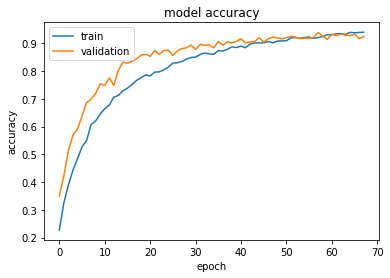

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**Gráfica de los resultados de pérdidas en el entrenamiento y validación.**

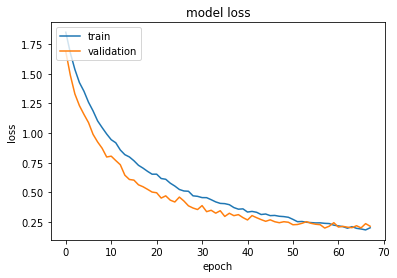

In [13]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**Eleccion del mejor modelo y su almacenamiento**

In [14]:
#%% Mejor modelo
model_best = load_model('best_model.h5')

score = model_best.evaluate(x=X_test,
                            y=y_test,
                            batch_size=64)

16/16 [==============================] - 5s 275ms/step - loss: 0.2353 - accuracy: 0.9183


#**Segundo modelo de DL con cuatro capas convolucionales**
---





**Construcción del modelo y compilación**

In [1]:
#%% Construimos el segundo modelo propuesto y lo compilamos
model = Sequential()
input_shape=(128, 128, 1)

model.add(Conv2D(32, (4, 10), padding="same",
input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(32, (4, 10), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(32, (4, 10), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(32, (4, 10), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Dense(7))
model.add(Activation("softmax"))

adam = Adam(0.0001)

model.compile(
   optimizer=adam,
   loss="categorical_crossentropy",
   metrics=['accuracy'])


NameError: ignored

**Entrenamiento del modelo**

In [15]:
# Entrenando el segundo modelo
#%% Entrenamos el modelo
callbacks = [ModelCheckpoint(filepath='best_model.h5', verbose=1,
                              monitor='val_loss', save_best_only=True,
                              mode='min'),
             EarlyStopping(monitor='val_loss', patience=10, verbose=1,
                              mode='min')]

history = model.fit(
    x=X_train,
    y=y_train,
    epochs=50,
    batch_size=64,
    validation_data= (X_valid, y_valid),
    callbacks=callbacks)

Epoch 1/50
70/72 [============================>.] - ETA: 0s - loss: 0.1344 - accuracy: 0.9549
Epoch 1: val_loss improved from inf to 0.25936, saving model to best_model.h5
72/72 [==============================] - 2s 22ms/step - loss: 0.1330 - accuracy: 0.9555 - val_loss: 0.2594 - val_accuracy: 0.9326
Epoch 2/50
70/72 [============================>.] - ETA: 0s - loss: 0.1289 - accuracy: 0.9587
Epoch 2: val_loss did not improve from 0.25936
72/72 [==============================] - 1s 20ms/step - loss: 0.1291 - accuracy: 0.9582 - val_loss: 0.2809 - val_accuracy: 0.9234
Epoch 3/50
70/72 [============================>.] - ETA: 0s - loss: 0.1365 - accuracy: 0.9567
Epoch 3: val_loss did not improve from 0.25936
72/72 [==============================] - 1s 20ms/step - loss: 0.1363 - accuracy: 0.9564 - val_loss: 0.2830 - val_accuracy: 0.9326
Epoch 4/50
70/72 [============================>.] - ETA: 0s - loss: 0.1366 - accuracy: 0.9569
Epoch 4: val_loss did not improve from 0.25936
72/72 [========

**Grafica de la exactitud por epocas**

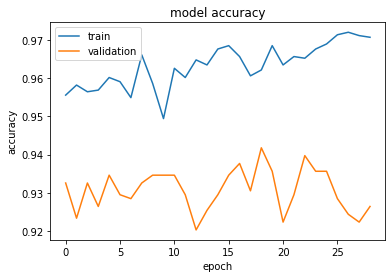

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**Grafica de las perdidas por epocas**

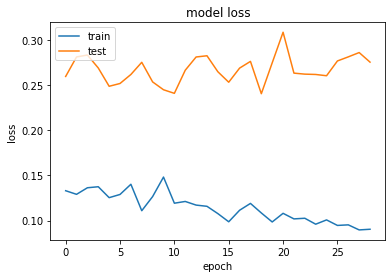

In [19]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Elección del mejor modelo**

In [20]:
#%% Mejor modelo
model_best = load_model('best_model.h5')

score = model_best.evaluate(x=X_test,
                            y=y_test,
                            batch_size=64)

16/16 [==============================] - 0s 9ms/step - loss: 0.1903 - accuracy: 0.9418
